<a href="https://colab.research.google.com/github/sraycju/BrainTumorSegmentation/blob/main/Skull_Stripping_with_3D_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
!pip install deepbrain

In [ ]:
from deepbrain import Extractor

In [ ]:
!pip install tensorflow

In [ ]:
img=nib.load('/content/drive/MyDrive/NFBS_Skull_Stripped/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w.nii.gz')
print('Shape of image=',img.shape)

Shape of image= (256, 256, 192)


In [ ]:
#storing the address of 3 types of files
import os
brain_mask=[]
brain=[]
raw=[]
for subdir, dirs, files in os.walk('/content/drive/MyDrive/NFBS_Skull_Stripped/NFBS_Dataset'):
    for file in files:
        #print os.path.join(subdir, file)y
        filepath = subdir + os.sep + file

        if filepath.endswith(".gz"):
          if '_brainmask.' in filepath:
            brain_mask.append(filepath)
          elif '_brain.' in filepath:
            brain.append(filepath)
          else:
            raw.append(filepath)


# print(brain_mask)
# print(brain)
# print(raw)


In [ ]:
!pip install SimpleITK nibabel matplotlib

In [ ]:
!pip install nipype

In [ ]:
from nipype.interfaces.ants import N4BiasFieldCorrection

In [ ]:
import nibabel as nib
import numpy as np

for i in tqdm(range(len(raw))):
  # Load the image data
  img = nib.load(raw[i])
  img_data = img.get_fdata()

  # Perform median intensity normalization
  median = np.median(img_data)
  bias_corrected_data = np.divide(img_data, median)

  # Create a new Nifti1Image from the bias corrected data
  bias_corrected_img = nib.Nifti1Image(bias_corrected_data, img.affine, img.header)

  # Save the corrected image
  nib.save(bias_corrected_img, f'/content/drive/MyDrive/bias_correction/corrected_image_{i}.nii.gz')


100%|██████████| 125/125 [06:20<00:00,  3.04s/it]


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom


for i in range(len(raw)):

  # Load the NIFTI image
  img = nib.load(raw[i])
  raw_data = img.get_fdata()

  # Load the NIFTI mask
  img2 = nib.load(brain_mask[i])
  mask_data = img2.get_fdata()

  # Define the target resolution
  zoom_factor = 2 # scale by 2
  target_shape = (96,128,160)

  # Resample the image
  resampled_data = zoom(raw_data, zoom=zoom_factor, order=0)
  resampled_img = nib.Nifti1Image(resampled_data, img.affine)
  nib.save(resampled_img, f'/content/drive/MyDrive/resized/raw/resampled_raw_{i}.nii.gz') 


  # Resample the mask
  resampled_data = zoom(mask_data, zoom=zoom_factor, order=0)
  resampled_img = nib.Nifti1Image(resampled_data, img.affine)
  nib.save(resampled_img, f'/content/drive/MyDrive/resized/mask/resampled_mask{i}.nii.gz')


29


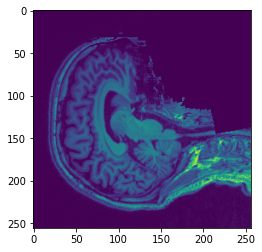

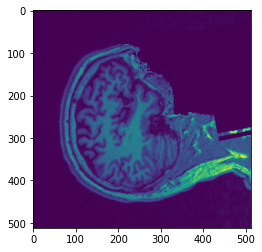

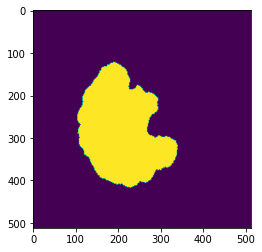

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import random

idx = random.randint(0,123)
print(idx)

img = nib.load(raw[idx])
data = img.get_fdata()


img_raw = nib.load(f'/content/drive/MyDrive/resized/raw/resampled_raw_{idx}.nii.gz')
img_corrected = nib.load(f'/content/drive/MyDrive/resized/mask/resampled_mask{idx}.nii.gz')

img_data = img_raw.get_fdata()
corrected_data = img_corrected.get_fdata()

plt.imshow(data[:,:,100])
plt.show()

plt.imshow(img_data[:,:,100])
plt.show()
# plt.axis('off')

plt.imshow(corrected_data[:,:,100])
plt.show()

In [ ]:
import SimpleITK as sitk
from tqdm import tqdm

for i in tqdm(range(len(raw))):
  image = sitk.ReadImage(f'/content/drive/MyDrive/resized/raw/resampled_raw_{i}.nii.gz')
  resacleFilter = sitk.RescaleIntensityImageFilter()
  resacleFilter.SetOutputMaximum(255)
  resacleFilter.SetOutputMinimum(0)
  image = resacleFilter.Execute(image)
  sitk.WriteImage(image,f'/content/drive/MyDrive/resized/raw/resampled_normlised_raw_{i}.nii.gz')

100%|██████████| 125/125 [20:17<00:00,  9.74s/it]


In [ ]:
def data_gen(self,img_list, mask_list, batch_size):
    '''Custom data generator to feed image to model'''
    c = 0
    n = [i for i in range(len(img_list))]  #List of training images
    random.shuffle(n)
    
    while (True):
      img = np.zeros((batch_size, 96, 128, 160,1)).astype('float')   #adding extra dimensions as conv3d takes file of size 5
      mask = np.zeros((batch_size, 96, 128, 160,1)).astype('float')

      for i in range(c, c+batch_size): 
        train_img = nib.load(img_list[n[i]]).get_data()
        
        train_img=np.expand_dims(train_img,-1)
        train_mask = nib.load(mask_list[n[i]]).get_data()

        train_mask=np.expand_dims(train_mask,-1)

        img[i-c]=train_img
        mask[i-c] = train_mask
      c+=batch_size
      if(c+batch_size>=len(img_list)):
        c=0
        random.shuffle(n)

      yield img,mask


In [ ]:
def convolutional_block(input, filters=3, kernel_size=3, batchnorm = True):
    '''conv layer followed by batchnormalization'''
    x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size,kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size,kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x


In [ ]:
def resunet_opt(input_img, filters = 64, dropout = 0.2, batchnorm = True):
    """Residual 3D Unet"""
    conv1 = convolutional_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)
    drop1 = Dropout(dropout)(pool1)

    conv2 = convolutional_block(drop1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)
    drop2 = Dropout(dropout)(pool2)

    conv3 = convolutional_block(drop2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)
    drop3 = Dropout(dropout)(pool3)

    conv4 = convolutional_block(drop3, filters * 8, kernel_size = 3, batchnorm = batchnorm)
    pool4 = MaxPooling3D((2, 2, 2))(conv4)
    drop4 = Dropout(dropout)(pool4)

    conv5 = convolutional_block(drop4, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    conv5 = convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    ups6 = Conv3DTranspose(filters * 8, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv5)
    ups6 = concatenate([ups6, conv4])
    ups6 = Dropout(dropout)(ups6)
    conv6 = convolutional_block(ups6, filters * 8, kernel_size = 3, batchnorm = batchnorm)

    ups7 = Conv3DTranspose(filters * 4, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv6)
    ups7 = concatenate([ups7, conv3])
    ups7 = Dropout(dropout)(ups7)
    conv7 = convolutional_block(ups7, filters * 4, kernel_size = 3, batchnorm = batchnorm)

    ups8 = Conv3DTranspose(filters * 2, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv7)
    ups8 = concatenate([ups8, conv2])
    ups8 = Dropout(dropout)(ups8)
    conv8 = convolutional_block(ups8, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    ups9 = Conv3DTranspose(filters * 1, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv8)
    ups9 = concatenate([ups9, conv1])
    ups9 = Dropout(dropout)(ups9)
    conv9 = convolutional_block(ups9, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv3D(1, (1, 1, 2), activation='sigmoid',padding='same')(conv9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def training(self,epochs):
    im_height=96
    im_width=128
    img_depth=160
    epochs=60
    train_gen = data_gen(self.X_train,self.y_train, batch_size = 4)
    val_gen = data_gen(self.X_test,self.y_test, batch_size = 4)
    channels=1
    input_img = Input((im_height, im_width,img_depth,channels), name='img')
    self.model = resunet_opt(input_img, filters=16, dropout=0.05, batchnorm=True)
    self.model.summary()
    self.model.compile(optimizer=Adam(lr=1e-1),loss=focal_loss,metrics=[iou_score,'accuracy'])
    #fitting the model
    callbacks=callbacks = [
        ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=False)]
    result=self.model.fit(train_gen,steps_per_epoch=16,epochs=epochs,validation_data=val_gen,validation_steps=16,initial_epoch=0,callbacks=callbacks)